In [1]:
import pandas as pd

In [ ]:
import os
import rasterio
import numpy as np
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Input
from tensorflow.keras.callbacks import EarlyStopping

class NDVIPreprocessing:
    def read_band(self, file_path, band_number):
        try:
            with rasterio.open(file_path) as src:
                band = src.read(band_number)
                profile = src.profile
            return band, profile
        except rasterio.errors.RasterioIOError as e:
            print(f"Error opening file {file_path}: {e}")
            return None, None

    def ndvi_raster_img(self, file_path, red_num, nir_num):
        red_band, _ = self.read_band(file_path, red_num)
        nir_band, _ = self.read_band(file_path, nir_num)
        if red_band is None or nir_band is None:
            return None
        ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-10)
        return ndvi

    def pad_or_crop(self, img, target_shape):
        target_height, target_width = target_shape
        height, width = img.shape

        if height > target_height or width > target_width:
            # Crop the image
            startx = width // 2 - (target_width // 2)
            starty = height // 2 - (target_height // 2)
            return img[starty:starty + target_height, startx:startx + target_width]

        else:
            # Pad the image
            padded_img = np.zeros(target_shape, dtype=img.dtype)
            startx = target_width // 2 - (width // 2)
            starty = target_height // 2 - (height // 2)
            padded_img[starty:starty + height, startx:startx + width] = img
            return padded_img

    def create_dataset(self, directory, target_shape):
        files = sorted(os.listdir(directory))
        ndvi_list = []
        for file in files:
            file_path = os.path.join(directory, file)
            print(f"Processing file: {file_path}")
            ndvi_raster = self.ndvi_raster_img(file_path, 8, 4)
            if ndvi_raster is not None:
                ndvi_raster = self.pad_or_crop(ndvi_raster, target_shape)
                ndvi_list.append(ndvi_raster)
            else:
                print(f"Skipping file due to read error: {file_path}")
        return ndvi_list[62:]
    

processor = NDVIPreprocessing()
path = 'assets/qgis/1'
target_shape = (64,64)
ndvi_list = processor.create_dataset(path, target_shape)

In [27]:
def normalize_ndvi(ndvi_list):
  normalize_ndvi_list = []
  for ndvi_data in ndvi_list:
    for i in range(ndvi_data.shape[0]):
      for j in range(ndvi_data.shape[1]):
        if ndvi_data[i][j] == 0:
          ndvi_data[i][j] = 0.
        else:
          ndvi_data[i][j] = float((ndvi_data[i][j] + 1)/2)
    normalize_ndvi_list.append(ndvi_data)
  return normalize_ndvi_list

In [28]:
ndvi_data = normalize_ndvi(ndvi_list)

In [30]:
# Convert the list to a NumPy array
ndvi_stack = np.stack(ndvi_data, axis=-1)  # Shape: (height, width, num_time_steps)

# Extract time series for each pixel
def extract_time_series(data):
    height, width, num_time_steps = data.shape
    time_series = np.zeros((height, width, num_time_steps))
    
    for y in range(height):
        for x in range(width):
            time_series[y, x, :] = data[y, x, :]
    
    return time_series

time_series_data = extract_time_series(ndvi_stack)  # Shape: (height, width, num_time_steps)


In [31]:
time_series_data.shape

(64, 64, 147)

In [32]:
def create_sequences(data, window_size):
    height, width, num_time_steps = data.shape
    sequences = []
    targets = []
    
    for y in range(height):
        for x in range(width):
            pixel_time_series = data[y, x, :]
            for i in range(60, num_time_steps - window_size):
                sequences.append(pixel_time_series[i:i + window_size])
                targets.append(pixel_time_series[i + window_size])
    
    return np.array(sequences), np.array(targets)

# Set the window size
window_size = 4  # Example: 4 weeks

# Create sequences and targets
sequences, targets = create_sequences(time_series_data, window_size)

In [33]:
sequences.shape

(339968, 4)

In [11]:
from tensorflow.keras.optimizers import Adam

In [34]:
# Define the LSTM model
model = Sequential()
model.add(Input(shape=(window_size, 1)))  # Input shape: (sequence_length, features)
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(1))  # Output shape: (1) for regression
optim = Adam(learning_rate=0.005)
model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(sequences, targets, epochs=100, batch_size=1024, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0213 - val_loss: 0.0030
Epoch 2/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0077 - val_loss: 0.0030
Epoch 3/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 4/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 5/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 6/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 7/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 8/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0075 - val_loss: 0.0029
Epoch 9/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0075 - val_loss: 0.0029
Epoch 10/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0075 - val_loss: 0.0029
Epoch 11/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 12/100
266/266 ━━━━━━━━━━━━━━━━━━━━

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']

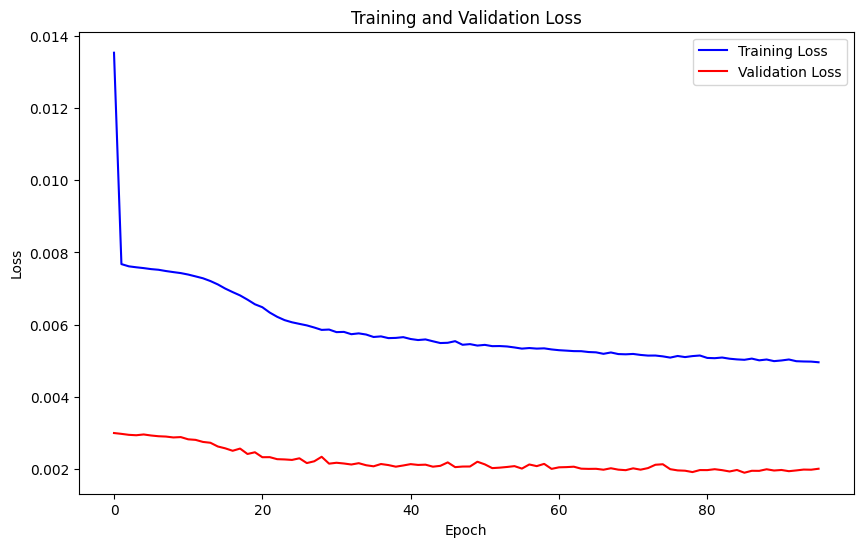

In [36]:
import matplotlib.pyplot as plt 
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(loss, label='Training Loss', color='blue')

# Plot validation loss
plt.plot(val_loss, label='Validation Loss', color='red')

# Add title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [37]:
processor1 = NDVIPreprocessing()
path1 = 'assets/qgis/hungson2'
target_shape1 = (64,64)
ndvi_list1 = processor.create_dataset(path1, target_shape1)

Processing file: assets/qgis/hungson2\mask_2020-01-01_2020-01-08.tif
Processing file: assets/qgis/hungson2\mask_2020-01-08_2020-01-15.tif
Processing file: assets/qgis/hungson2\mask_2020-01-15_2020-01-22.tif
Processing file: assets/qgis/hungson2\mask_2020-01-22_2020-01-29.tif
Processing file: assets/qgis/hungson2\mask_2020-01-29_2020-02-05.tif
Processing file: assets/qgis/hungson2\mask_2020-02-05_2020-02-12.tif
Processing file: assets/qgis/hungson2\mask_2020-02-12_2020-02-19.tif
Processing file: assets/qgis/hungson2\mask_2020-02-19_2020-02-26.tif
Processing file: assets/qgis/hungson2\mask_2020-02-26_2020-03-04.tif
Processing file: assets/qgis/hungson2\mask_2020-03-04_2020-03-11.tif
Processing file: assets/qgis/hungson2\mask_2020-03-11_2020-03-18.tif
Processing file: assets/qgis/hungson2\mask_2020-03-18_2020-03-25.tif
Processing file: assets/qgis/hungson2\mask_2020-03-25_2020-04-01.tif
Processing file: assets/qgis/hungson2\mask_2020-04-01_2020-04-08.tif
Processing file: assets/qgis/hungs

In [38]:
ndvi_stack1 = np.stack(ndvi_list1, axis=-1) 
t_data = extract_time_series(ndvi_stack1)
t_data_seq, targets_seq = create_sequences(t_data, 4)

In [39]:
t_data_seq.shape

(339968, 4)

In [64]:
import numpy as np

def predict_ndvi_at_t(model, data, window_size, t):
    """
    Dự đoán giá trị NDVI tại thời điểm t.
    
    Parameters:
    - model: Mô hình LSTM đã huấn luyện.
    - data: Dữ liệu NDVI đầu vào (dưới dạng numpy array) với kích thước (height, width, num_time_steps).
    - window_size: Kích thước cửa sổ thời gian đã sử dụng trong huấn luyện.
    - t: Thời điểm t tại đó bạn muốn dự đoán giá trị NDVI.
    
    Returns:
    - Dự đoán giá trị NDVI tại thời điểm t.
    """
    height, width, num_time_steps = data.shape
    
    # Tạo mảng trống để chứa các dự đoán
    predictions = np.zeros((height, width))
    
    for y in range(height):
        for x in range(width):
            pixel_time_series = data[y, x, :]
            if t >= window_size and t < num_time_steps:
                # Lấy dữ liệu đầu vào cho thời điểm t
                input_sequence = pixel_time_series[t - window_size:t].reshape(1, window_size, 1)
              
                # Dự đoán giá trị NDVI tại thời điểm t
                prediction = model.predict(input_sequence)
                
                # Lưu dự đoán vào mảng dự đoán
                predictions[y, x] = prediction
    
    return predictions


In [65]:
window_size = 4 
t = 4  # Ví dụ: thời điểm thứ 100
# Dự đoán giá trị NDVI tại thời điểm t
predicted_ndvi = predict_ndvi_at_t(model, t_data, window_size, t)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

C:\Users\vgm1\AppData\Local\Temp\ipykernel_16092\3634845380.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[y, x] = prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [66]:
predicted_ndvi.max()

0.0

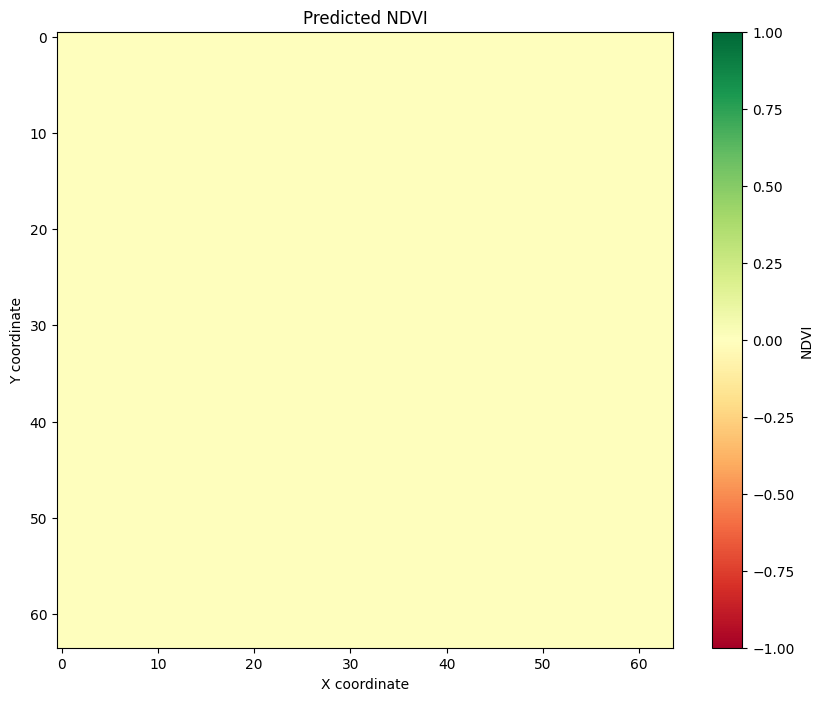

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Vẽ dữ liệu NDVI dự đoán
def plot_ndvi(ndvi_data, title='Predicted NDVI'):
    plt.figure(figsize=(10, 8))
    plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label='NDVI')
    plt.title(title)
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()
# Vẽ raster NDVI dự đoán
plot_ndvi(predicted_ndvi)

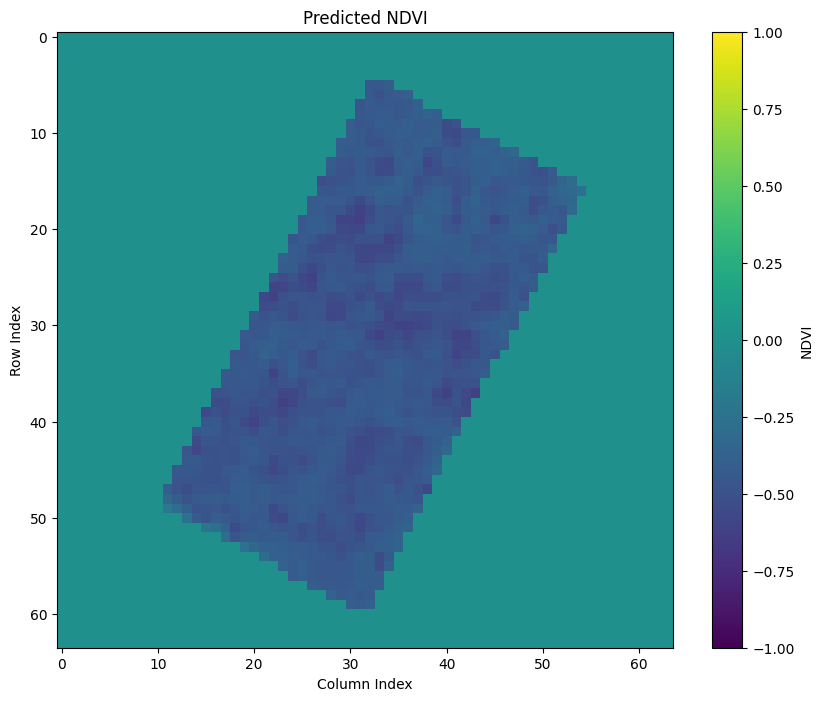

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Vẽ dữ liệu NDVI dự đoán
def plot_ndvi(ndvi_data, title='Predicted NDVI', cmap='viridis'):
    plt.figure(figsize=(10, 8))
    plt.imshow(ndvi_data, cmap=cmap, vmin=-1, vmax=1)  # Điều chỉnh vmin và vmax theo phạm vi NDVI của bạn
    plt.colorbar(label='NDVI')
    plt.title(title)
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

# Vẽ raster NDVI dự đoán
plot_ndvi(ndvi_list1[3])